In [0]:
import os
import sys
import cv2
import numpy  as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K  
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv3D, Flatten, Lambda, Activation, Dropout, MaxPooling3D

## **Ingresando a Drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## ***Tratando el flujo***

In [0]:
def scale_ycrcb(img_ycrcb):
    """
    Retorna una imagen escalada en (-128,128)
    """
    tem = np.zeros(img_ycrcb.shape, dtype=int)
    tem[:,:,0] = img_ycrcb[:,:,0]
    tem[:,:,1] = img_ycrcb[:,:,1] + (-128)
    tem[:,:,2] = img_ycrcb[:,:,2] + (-128)
    return tem

In [0]:
def arrowsimg(array_dydx, defacing = 0):
    """
    image_dydx: dydx Channels of an image (2D)
    defacing: If the reference map is defacing with respect to the YCrCb map
    return: magnitudes and angles of the arrows
    """
    #___________________________________________________________________________
    assert(array_dydx.ndim == 3), "The array is not 3D array"
    assert(array_dydx.shape[2] == 2), "Dimension is not valid (Channels)"
    #___________________________________________________________________________
    array_dydx = np.array(array_dydx)
    magnitudes, angles = cv2.cartToPolar(array_dydx[:,:,1].astype(float),
                                         array_dydx[:,:,0].astype(float),
                                         angleInDegrees=True)
    if defacing != 0:
        for row in range(angles.shape[0]):
            for col in range(angles.shape[1]):
                angle = angles[row,col]
                if (0.0 <= angle < 90.0 ): # first quadrant
                    angles[row,col] = angle + (360 - defacing)
                elif (90.0 <= angle < 180.0 ): # second quadrant
                    if defacing == 90:
                        angles[row,col] = angle - defacing
                    else:
                        angles[row,col] = angle + (360 - defacing)
                elif (180.0 <= angle < 270.0 ): # third quadrant
                    if defacing == 270:
                        angles[row,col] = angle + (360 - defacing)
                    else:
                        angles[row,col] = angle - defacing
                elif (270.0 <= angle <= 360.0 ): # fourth quadrant
                    angles[row,col] = angle - defacing

    return magnitudes, angles

## ***Cinemáticas***

***Velocidad normal***

In [0]:
def vel_normal(vty1,vtx1,mag1,vty2,vtx2):
    
    w=vtx1.shape[0]   #y
    h=vtx1.shape[1]   #x
    vty_dev=np.zeros((w,h))
    vtx_dev=np.zeros((w,h))  
    for i in range(w):
        for j in range(h):
            if(round(i+mag1[i,j])>=w or round(j+mag1[i,j])>=h):
                vty_dev[i,j]=0
                vtx_dev[i,j]=0
            else:
                vty_dev[i,j]=vty2[int(round(i+mag1[i,j])),int(round(j+mag1[i,j]))]-vty1[i,j]
                vtx_dev[i,j]=vtx2[int(round(i+mag1[i,j])),int(round(j+mag1[i,j]))]-vtx1[i,j]
    
    mag_dev,d_dev=cv2.cartToPolar(vtx_dev,vty_dev)    #cartTopolar(x,y)
    vny,vnx=vel_tang(mag_dev,vty_dev,vtx_dev)
    return vny,vnx,mag_dev

***Velocidad tangencial***

In [0]:
def vel_tang(mag,y,x):
    vty,vtx=np.zeros((mag.shape[0],mag.shape[1])),np.zeros((mag.shape[0],mag.shape[1]))
    for i in range(mag.shape[0]):
        for j in range(mag.shape[1]):
            if(mag[i,j]==0):
                vty[i,j]=0
                vtx[i,j]=0
            else:
                vty[i,j]=y[i,j]/mag[i,j]
                vtx[i,j]=x[i,j]/mag[i,j]
    return vty,vtx

***Aceleración normal***

In [0]:
def acl_normal(f_mag,mag_vn):
    w=f_mag.shape[0]   #y
    h=f_mag.shape[1]   #x
    an=np.zeros((w,h)) 
    for i in range(w):
        for j in range(h):
            an[i,j]=f_mag[i,j]*mag_vn[i,j]
    
    return an

***Aceleración tangencial***

In [0]:
def acl_tan(mag1,mag2):
    
    w=mag1.shape[0]   #y
    h=mag1.shape[1]   #x
    mag_dev=np.zeros((w,h))  
    for i in range(w):
        for j in range(h):
            if(round(i+mag1[i,j])>=w or round(j+mag1[i,j])>=h):
                mag_dev[i,j]=0                
            else:
                mag_dev[i,j]=mag2[int(round(i+mag1[i,j])),int(round(j+mag1[i,j]))]-mag1[i,j]
    
    return mag_dev

***Calculando las características***

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Tesis/recortados_ventrículos.zip", 'r')
zip_ref.extractall("/content/gdrive/My Drive/Tesis/")
zip_ref.close()

In [0]:
def cinematic_features(pathology, slice_):
  folder = '/content/gdrive/My Drive/Tesis/OF-PPM/' + pathology + '/' + slice_ + '/'
  frames = sorted(glob(os.path.join(folder, '*.ppm')))
  cc_folder = '/'.join(folder.split('/')[:-4]) + '/AT-PPM/' + '/'.join(folder.split('/')[-3:-2])
  os.mkdir(cc_folder)
  cc_folder = '/'.join(folder.split('/')[:-4]) + '/AT-PPM/' + '/'.join(folder.split('/')[-3:-1])
  os.mkdir(cc_folder)
  print('Empezando a calcular la cinemática...')
  for i, image in enumerate(frames):
    image_name = image.split('/')[-1]
    print("Imaging prosesing... ")
  
    if(image != folder+'000029.ppm'):
      a = plt.imread(image)
      if (len(frames) == i+1):
          b = plt.imread(frames[0])
      else:
          b = plt.imread(frames[i+1])
      img_a = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
      img_b = cv2.cvtColor(b, cv2.COLOR_BGR2YCrCb)

      imgsc_a = scale_ycrcb(img_a)[:,:,1:]
      imgsc_b = scale_ycrcb(img_b)[:,:,1:]
      mag_a, ang_a = arrowsimg(imgsc_a, 90)
      mag_b, ang_b = arrowsimg(imgsc_b, 90)
      
      #Charging cinematics
      vty_a, vtx_a = vel_tang(mag_a,imgsc_a[:,:,0], imgsc_a[:,:,1]) #VT_A        
      vty_b, vtx_b = vel_tang(mag_b,imgsc_b[:,:,0], imgsc_b[:,:,1]) #VT_B
      mag_vt = np.sqrt((vtx_a)**2 + (vty_a)**2)
      vny, vnx, mag_vn = vel_normal(vty_a, vtx_a,mag_a,vty_b,vtx_b) #VN
      mag_dev = acl_tan(mag_a,mag_b) #AT
      an_ = acl_normal(mag_a,mag_vn) #AN
      an_img = np.array(mag_dev, dtype = np.uint8)
      cinematic = cv2.applyColorMap(an_img, cv2.COLORMAP_JET)
      cv2.imwrite( cc_folder + '/' + image_name[:-4] + '.jpg', cinematic)
      print('Saving...' + cc_folder + '/' + image_name[:-4] + '.jpg')
   
 
  #return an_
#cinematic_features('SC-HF-I-01', '7')

In [0]:
first_pat = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/pri_pat.txt', 'r')
secon_pat = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/seg_pat.txt', 'r')
third_pat = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/ter_pat.txt', 'r')
four_pat  = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/cua_pat.txt', 'r')

In [0]:
print("First pathology")
for i in first_pat:
  pathology, slice_ = i.split(' ')[:2] 
  pathology = '0'+pathology[2:]
  cinematic_features(pathology, slice_)
#"""
print("Second pathology")
for i in secon_pat:
  pathology, slice_ = i.split(' ')[:2]
  pathology = '1'+pathology[2:]
  cinematic_features(pathology, slice_)
    
    
print("Third pathology")
for i in third_pat:
  pathology, slice_ = i.split(' ')[:2]
  pathology = '2'+pathology[2:]
  cinematic_features(pathology, slice_)
    
    
print("Four pathology")
for i in four_pat:
  pathology, slice_ = i.split(' ')[:2]
  pathology = '3'+pathology[2:]
  cinematic_features(pathology, slice_)
#"""

First pathology
Empezando a calcular la cinemática...
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000010.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000011.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000012.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000013.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000014.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000015.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000016.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000017.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000018.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000019.jpg
Imaging prosesing... 
Savi

## *Creando el train y test*

In [0]:
def creating_train(path, cinematica):
  X_train, paths = [], []
  for folder_path in path:
    path_P1 = folder_path.strip().split(" ")[:2]
    path_P1 = '/content/gdrive/My Drive/Tesis/'+cinematica+'/'+path_P1[0]+"/"+path_P1[1]+"/"
    paths.append(path_P1)
    folders_P1 = sorted(glob(os.path.join(path_P1, '*.ppm')))
    imagenes = []
    for images in folders_P1:
        img = plt.imread(images)
        imagenes.append(img)
    X_train.append(imagenes)
  return np.array(X_train), np.array(paths)

In [0]:
first = ['0-HF-I-01 7','0-HF-I-02 3','0-HF-I-05 7','0-HF-I-06 4','0-HF-I-07 4','0-HF-I-08 3','0-HF-I-09 9','0-HF-I-10 9','0-HF-I-11 3','0-HF-I-12 2','0-HF-I-40 4',
         '1-HF-NI-03 3','1-HF-NI-04 2','1-HF-NI-07 3','1-HF-NI-11 8','1-HF-NI-12 4','1-HF-NI-13 8','1-HF-NI-14 8','1-HF-NI-15 6','1-HF-NI-31 6','1-HF-NI-33 3','1-HF-NI-34 8','1-HF-NI-36 6',
         '2-HYP-01 4','2-HYP-03 3','2-HYP-06 6','2-HYP-07 7','2-HYP-08 5','2-HYP-09 8','2-HYP-10 2','2-HYP-11 8','2-HYP-12 3','2-HYP-37 7','2-HYP-38 3','2-HYP-40 5',
         '3-N-02 6','3-N-03 9','3-N-05 3','3-N-06 6','3-N-07 9','3-N-09 7','3-N-10 8','3-N-11 2','3-N-40 8']

## *Red Neuronal (Conv3D)*

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=4, dim=(20,256,256,3),
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            for j,img in enumerate(sorted(os.listdir(ID))): 
                # Store img
                #print(ID+img)
                X[i,j,:] = plt.imread(ID+img)
            #print(X[i,j])
            # Store class
            if(int(ID.split('/')[-3].split('-')[0]) == 3):
              y[i]=1
            elif(int(ID.split('/')[-3].split('-')[0]) == 2):
              y[i]=0
            elif(int(ID.split('/')[-3].split('-')[0]) == 1):
              y[i]=0
            else:
              y[i] = int(ID.split('/')[-3].split('-')[0])
            #print(y[i])
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes) 

In [0]:
def CNN3D(inputShape, dropout, nClass, wDecay):
    inputs = Input(inputShape)
    layer = Conv3D(filters=32, kernel_size=(3,3,3), strides=(2,2,2), kernel_regularizer=regularizers.l2(wDecay),data_format='channels_last')(inputs)
    layer = Activation('relu')(layer)
    layer = MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), data_format='channels_last')(layer)
    layer = Conv3D(filters=64, kernel_size=(3,3,3), strides=(1,1,1), kernel_regularizer=regularizers.l2(wDecay),data_format='channels_last')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), data_format='channels_last')(layer)
    layer = Conv3D(filters=128, kernel_size=(3,3,3), strides=(2,2,2), kernel_regularizer=regularizers.l2(wDecay),data_format='channels_last')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), data_format='channels_last')(layer)
    layer = Flatten()(layer)
    dense = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(wDecay))(layer)
    dense = Dropout(dropout)(dense)
    dense = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(wDecay))(dense)
    dense = Dropout(dropout)(dense)
    output = Dense(nClass, activation='sigmoid')(dense)
    model = Model(inputs = [inputs], outputs = [output], name='Convolutional3D')
        
    return model

In [8]:
K.set_floatx('float32')
K.set_image_data_format('channels_last')  
model = CNN3D((20, 256, 256, 3), 0.4, 2, 0.001)
sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
model.summary()

W0731 10:29:48.943634 140470204385152 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "Convolutional3D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 256, 256, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 9, 127, 127, 32)   2624      
_________________________________________________________________
activation (Activation)      (None, 9, 127, 127, 32)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 63, 63, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 61, 61, 64)     55360     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 61, 61, 64)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 30, 30, 64) 

In [0]:
def classify(X):
    model_c, pred = [], []
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    i = 1;
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        print(X_train.shape, X_test.shape, "Iteración: ", i)
        training_generator = DataGenerator(X_train)
        validation_generator = DataGenerator(X_test, batch_size=1) 
        model = CNN3D((20, 256, 256, 3), 0.4, 2, 0.001)
        
        sgd = optimizers.SGD(lr=0.01, decay=0.1, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
        model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])
        model_cinematic = model.fit_generator(generator=training_generator,
                                              use_multiprocessing=True,
                                              workers=4,
                                              epochs=20)
        p = model.predict(validation_generator)
        #print(p)
        pred.append(p)
        model_c.append(model_cinematic)
        model.save('/content/gdrive/My Drive/Tesis/models/patient_'+ str(i) +'.h5')
        i = i+1
    return model_cinematic, pred

## ***PPM - BINARIO***

In [39]:
X_train_PPM, paths_PPM = creating_train(first, 'PPM')
print(X_train_PPM.shape)
paths_PPM.shape

(44, 20, 256, 256, 3)


(44,)

In [139]:
history_PPM1, prediction_PPM1 = classify(paths_PPM[:23])

(22,) (1,) Iteración:  1
Epoch 1/20
5/5 [==============================] - 6s 1s/step - loss: 6.7733 - acc: 0.5000
Epoch 2/20
5/5 [==============================] - 4s 703ms/step - loss: 5.9444 - acc: 0.5750
Epoch 3/20
5/5 [==============================] - 3s 681ms/step - loss: 3.9830 - acc: 0.5250
Epoch 4/20
Epoch 3/20
5/5 [==============================] - 4s 837ms/step - loss: 3.9154 - acc: 0.6250
Epoch 5/20
5/5 [==============================] - 4s 714ms/step - loss: 3.5861 - acc: 0.7250
Epoch 6/20
5/5 [==============================] - 3s 690ms/step - loss: 3.4159 - acc: 0.7000
Epoch 7/20
5/5 [==============================] - 4s 763ms/step - loss: 3.8873 - acc: 0.5500
Epoch 8/20
5/5 [==============================] - 3s 648ms/step - loss: 3.5548 - acc: 0.7000
Epoch 9/20
5/5 [==============================] - 4s 701ms/step - loss: 3.4107 - acc: 0.7000
Epoch 10/20
5/5 [==============================] - 4s 716ms/step - loss: 3.4556 - acc: 0.7500
Epoch 11/20
5/5 [===================

W0731 02:20:14.098683 139797245724544 legend.py:1289] No handles with labels found to put in legend.


[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]


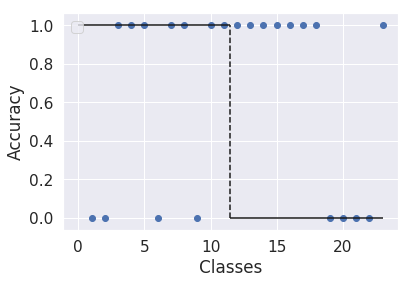

In [160]:
PRED_PPM1 = []
for i, value in enumerate(prediction_PPM1):
  value = value[0]
  if(value[0] > value[1]):
    PRED_PPM1.append(1)
  else:
    PRED_PPM1.append(0)
print(PRED_PPM1)
CLASSES_AN1 = np.arange(1,24)
plt.scatter(CLASSES_AN1, PRED_PPM1)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

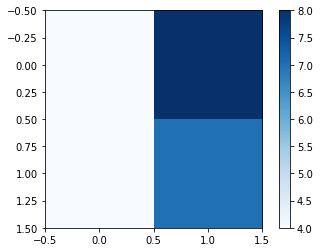

In [42]:
PRED_PPM1 = [0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
PRED_TRUEPPM1 = [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1]

cm_PPM1 = confusion_matrix(PRED_TRUEPPM1, PRED_PPM1)
plt.imshow(cm_PPM1, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar();

In [169]:
print("Accuracy: ", accuracy_score(PRED_TRUEPPM1, PRED_PPM1))
print("F1-Score: ", f1_score(PRED_TRUEPPM1, PRED_PPM1))     

Accuracy:  0.4782608695652174
F1-Score:  0.5384615384615385


***HF-I VS HYP***

In [11]:
PPM_2 = np.concatenate((paths_PPM[:11],paths_PPM[23:35]),axis=0)
print(PPM_2)
history_PPM2, prediction_PPM2 = classify(PPM_2)

W0731 10:35:42.350861 140470204385152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


['/content/gdrive/My Drive/Tesis/PPM/0-HF-I-01/7/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-02/3/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-05/7/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-06/4/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-07/4/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-08/3/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-09/9/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-10/9/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-11/3/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-12/2/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-40/4/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-01/4/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-03/3/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-06/6/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-07/7/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-08/5/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-09/8/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-10/2/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-11/8/'
 '/content/gdrive/My Drive/Tesis/PPM/2-

W0731 11:06:47.208744 140470204385152 legend.py:1289] No handles with labels found to put in legend.


[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]


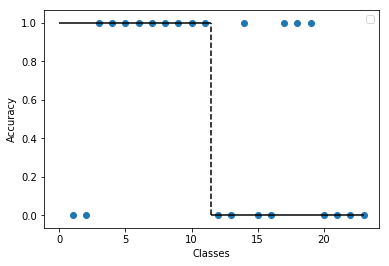

In [12]:
PRED_PPM2 = []
for i, value in enumerate(prediction_PPM2):
  value = value[0]
  if(value[0] > value[1]):
    PRED_PPM2.append(1)
  else:
    PRED_PPM2.append(0)
print(PRED_PPM2)
CLASSES_AN2 = np.arange(1,24)
plt.scatter(CLASSES_AN2, PRED_PPM2)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

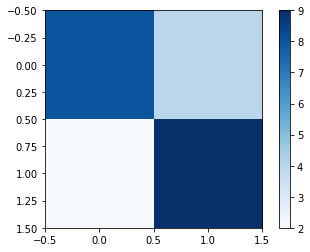

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

PRED_PPM2 = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]
PRED_TRUEPPM2 = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]

cm_PPM2 = confusion_matrix(PRED_TRUEPPM2, PRED_PPM2)
plt.imshow(cm_PPM2, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar();

In [15]:
print("Accuracy: ", accuracy_score(PRED_TRUEPPM2, PRED_PPM2))
print("F1-Score: ", f1_score(PRED_TRUEPPM2, PRED_PPM2))     

Accuracy:  0.7391304347826086
F1-Score:  0.7500000000000001


***HF-I VS N***

In [16]:
PPM_3 = np.concatenate((paths_PPM[:11],paths_PPM[35:]),axis=0)
print(PPM_3, PPM_3.shape)
history_PPM3, prediction_PPM3 = classify(PPM_3)

['/content/gdrive/My Drive/Tesis/PPM/0-HF-I-01/7/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-02/3/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-05/7/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-06/4/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-07/4/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-08/3/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-09/9/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-10/9/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-11/3/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-12/2/'
 '/content/gdrive/My Drive/Tesis/PPM/0-HF-I-40/4/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-02/6/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-03/9/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-05/3/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-06/6/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-07/9/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-09/7/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-10/8/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-11/2/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-40/8/'] (20,)


W0731 15:21:17.761166 140470204385152 legend.py:1289] No handles with labels found to put in legend.


[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


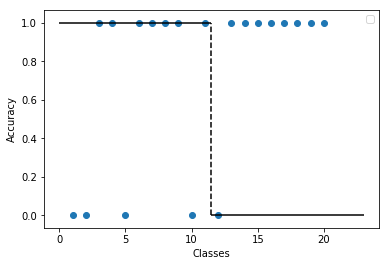

In [20]:
PRED_PPM3 = []
for i, value in enumerate(prediction_PPM3):
  value = value[0]
  if(value[0] > value[1]):
    PRED_PPM3.append(1)
  else:
    PRED_PPM3.append(0)
print(PRED_PPM3)
CLASSES_AN3 = np.arange(1,21)
plt.scatter(CLASSES_AN3, PRED_PPM3)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

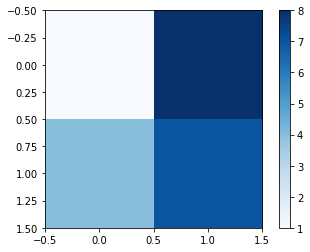

In [23]:
PRED_PPM3 = [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
PRED_TRUEPPM3 = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]

cm_PPM3 = confusion_matrix(PRED_TRUEPPM3, PRED_PPM3)
plt.imshow(cm_PPM3, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar();

In [24]:
print("Accuracy: ", accuracy_score(PRED_TRUEPPM3, PRED_PPM3))
print("F1-Score: ", f1_score(PRED_TRUEPPM3, PRED_PPM3))     

Accuracy:  0.4
F1-Score:  0.5384615384615385


***HF-IN VS HYP***

In [25]:
PPM_4 = paths_PPM[11:35]
print(PPM_4, PPM_4.shape)
history_PPM4, prediction_PPM4 = classify(PPM_4)

['/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-03/3/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-04/2/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-07/3/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-11/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-12/4/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-13/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-14/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-15/6/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-31/6/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-33/3/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-34/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-36/6/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-01/4/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-03/3/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-06/6/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-07/7/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-08/5/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-09/8/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-10/2/'
 '/content/gdrive/My Drive

W0731 16:12:00.796694 140470204385152 legend.py:1289] No handles with labels found to put in legend.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


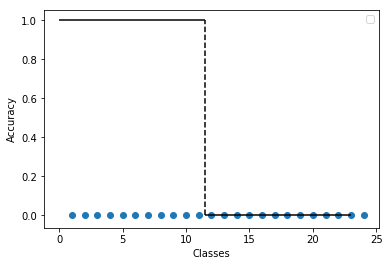

In [27]:
PRED_PPM4 = []
for i, value in enumerate(prediction_PPM4):
  value = value[0]
  if(value[0] > value[1]):
    PRED_PPM4.append(1)
  else:
    PRED_PPM4.append(0)
print(PRED_PPM4)
CLASSES_AN4 = np.arange(1,25)
plt.scatter(CLASSES_AN4, PRED_PPM4)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

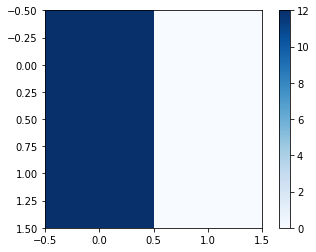

In [29]:
PRED_TRUEPPM4 = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]

cm_PPM4 = confusion_matrix(PRED_TRUEPPM4, PRED_PPM4)
plt.imshow(cm_PPM4, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar();

In [30]:
print("Accuracy: ", accuracy_score(PRED_TRUEPPM4, PRED_PPM4))
print("F1-Score: ", f1_score(PRED_TRUEPPM4, PRED_PPM4))     

Accuracy:  0.5
F1-Score:  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***HF-NI VS N***

In [31]:
PPM_5 = np.concatenate((paths_PPM[11:23],paths_PPM[35:]),axis=0)
print(PPM_5)
history_PPM5, prediction_PPM5 = classify(PPM_5)

['/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-03/3/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-04/2/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-07/3/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-11/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-12/4/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-13/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-14/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-15/6/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-31/6/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-33/3/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-34/8/'
 '/content/gdrive/My Drive/Tesis/PPM/1-HF-NI-36/6/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-02/6/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-03/9/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-05/3/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-06/6/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-07/9/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-09/7/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-10/8/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N

W0731 18:05:53.822998 140470204385152 legend.py:1289] No handles with labels found to put in legend.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


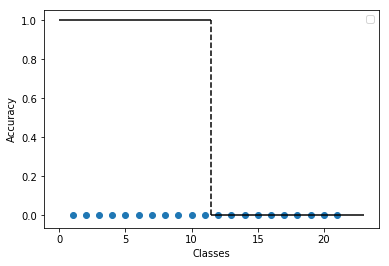

In [33]:
PRED_PPM5 = []
for i, value in enumerate(prediction_PPM5):
  value = value[0]
  if(value[0] > value[1]):
    PRED_PPM5.append(1)
  else:
    PRED_PPM5.append(0)
print(PRED_PPM5)
CLASSES_AN5 = np.arange(1,22)
plt.scatter(CLASSES_AN5, PRED_PPM5)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

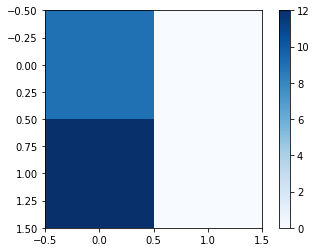

In [37]:
PRED_TRUEPPM5 = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]

cm_PPM5 = confusion_matrix(PRED_TRUEPPM5, PRED_PPM5)
plt.imshow(cm_PPM5, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar();

In [38]:
print("Accuracy: ", accuracy_score(PRED_TRUEPPM5, PRED_PPM5))
print("F1-Score: ", f1_score(PRED_TRUEPPM5, PRED_PPM5))     

Accuracy:  0.42857142857142855
F1-Score:  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


***HYP VS N***

In [41]:
PPM_6= paths_PPM[23:]
print(PPM_6)
history_PPM6, prediction_PPM6 = classify(PPM_6)

['/content/gdrive/My Drive/Tesis/PPM/2-HYP-01/4/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-03/3/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-06/6/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-07/7/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-08/5/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-09/8/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-10/2/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-11/8/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-12/3/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-37/7/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-38/3/'
 '/content/gdrive/My Drive/Tesis/PPM/2-HYP-40/5/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-02/6/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-03/9/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-05/3/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-06/6/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-07/9/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-09/7/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-10/8/'
 '/content/gdrive/My Drive/Tesis/PPM/3-N-11/2/'
 '/content/gdriv

W0731 18:56:16.679951 140470204385152 legend.py:1289] No handles with labels found to put in legend.


[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]


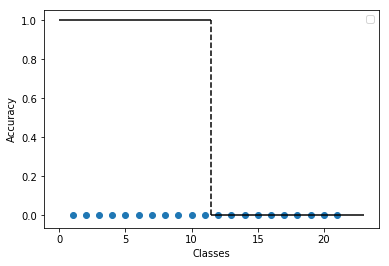

In [43]:
PRED_PPM6 = []
for i, value in enumerate(prediction_PPM6):
  value = value[0]
  if(value[0] > value[1]):
    PRED_PPM6.append(1)
  else:
    PRED_PPM6.append(0)
print(PRED_PPM6)
CLASSES_PPM6 = np.arange(1,22)
plt.scatter(CLASSES_PPM6, PRED_PPM5)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

Accuracy:  0.5714285714285714
F1-Score:  0.6086956521739131


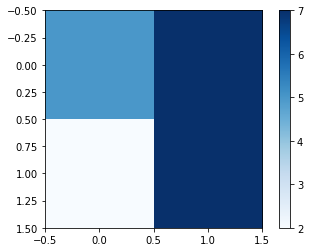

In [47]:
PRED_TRUEPPM6 = [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1]
PRED_PPM6= [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]

cm_PPM6 = confusion_matrix(PRED_TRUEPPM6, PRED_PPM6)
plt.imshow(cm_PPM6, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar();

print("Accuracy: ", accuracy_score(PRED_TRUEPPM6, PRED_PPM6))
print("F1-Score: ", f1_score(PRED_TRUEPPM6, PRED_PPM6))     

##***AN - BINARIO***

In [10]:
X_train_AN, paths_AN = creating_train(first, 'AN-PPM')
print(X_train_AN.shape)
paths_AN.shape

(44, 0)


(44,)

***Insuficiencia cardiaca con infarto VS Insuficiencia cardiaca sin infarto***

In [0]:
history_AN1, prediction_AN1 = classify(paths_AN[:23])

(22,) (1,) Iteración:  1
Epoch 1/20
5/5 [==============================] - 3s 523ms/step - loss: 7.3801 - acc: 0.4500
Epoch 2/20
5/5 [==============================] - 4s 706ms/step - loss: 5.4106 - acc: 0.5750
Epoch 3/20
5/5 [==============================] - 3s 643ms/step - loss: 5.9121 - acc: 0.3750
Epoch 4/20
5/5 [==============================] - 3s 645ms/step - loss: 4.8989 - acc: 0.4750
Epoch 5/20
5/5 [==============================] - 3s 681ms/step - loss: 3.9752 - acc: 0.5500
Epoch 6/20
5/5 [==============================] - 3s 597ms/step - loss: 3.9392 - acc: 0.5000
Epoch 7/20
5/5 [==============================] - 4s 738ms/step - loss: 3.7590 - acc: 0.5000
Epoch 8/20
5/5 [==============================] - 3s 680ms/step - loss: 3.7467 - acc: 0.5250
Epoch 9/20
5/5 [==============================] - 3s 681ms/step - loss: 3.5112 - acc: 0.6750
Epoch 10/20
5/5 [==============================] - 3s 670ms/step - loss: 3.5208 - acc: 0.6750
Epoch 11/20
5/5 [===========================

W0731 02:10:18.871267 139797245724544 legend.py:1289] No handles with labels found to put in legend.


[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]


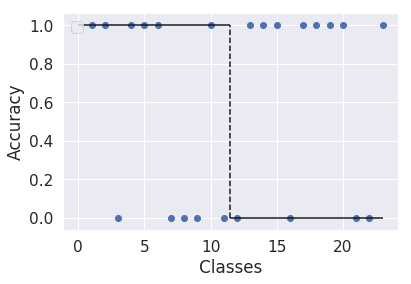

In [147]:
PRED_AN1 = []
for i, value in enumerate(prediction_AN1):
  value = value[0]
  if(value[0] > value[1]):
    PRED_AN1.append(1)
  else:
    PRED_AN1.append(0)
print(PRED_AN1)
CLASSES_AN1 = np.arange(1,24)
plt.scatter(CLASSES_AN1, PRED_AN1)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

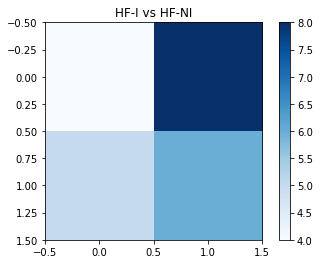

In [30]:
from sklearn.metrics import confusion_matrix

PRED_AN1 = [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
PRED_TRUEAN1 = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]
CM_AN1 = confusion_matrix(PRED_TRUEAN1, PRED_AN1)#, labels=['0', '1'])
plt.imshow(CM_AN1, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("HF-I vs HF-NI")
plt.colorbar();

In [166]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


print("Accuracy: ", accuracy_score(PRED_TRUEAN1, PRED_AN1))
print("F1-Score: ", f1_score(PRED_TRUEAN1, PRED_AN1))     

Accuracy:  0.43478260869565216
F1-Score:  0.4799999999999999


***Falla cardiaca con infarto VS Hypertrofia***

In [143]:
AN_2 = np.concatenate((paths_AN[:11],paths_AN[23:35]),axis=0)
print(AN_2)
history_AN2, prediction_AN2 = classify(AN_2)

['/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-01/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-02/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-05/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-06/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-07/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-08/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-09/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-10/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-11/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-12/2/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-40/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-01/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-03/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-06/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-07/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-08/5/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-09/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-10/2/'
 '/content/gdrive/My Drive/Tesis/AN

W0731 02:09:58.986322 139797245724544 legend.py:1289] No handles with labels found to put in legend.


[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]


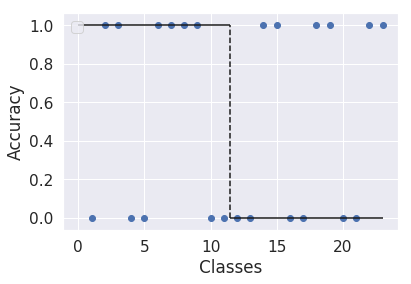

In [146]:
PRED_AN2 = []
for i, value in enumerate(prediction_AN2):
  value = value[0]
  if(value[0] > value[1]):
    PRED_AN2.append(1)
  else:
    PRED_AN2.append(0)
print(PRED_AN2)
CLASSES_AN2 = np.arange(1,24)
plt.scatter(CLASSES_AN2, PRED_AN2)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

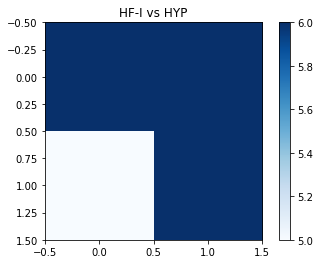

In [31]:
PRED_AN2 = [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]
PRED_TRUEAN2 = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]
cm_AN2 = confusion_matrix(PRED_TRUEAN2, PRED_AN2)
plt.imshow(cm_AN2, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("HF-I vs HYP")
plt.colorbar();

In [167]:
print("Accuracy: ", accuracy_score(PRED_TRUEAN2, PRED_AN2))
print("F1-Score: ", f1_score(PRED_TRUEAN2, PRED_AN2))     

Accuracy:  0.5217391304347826
F1-Score:  0.5217391304347826


***Falla cardiaca con infarto VS Normal***

In [162]:
AN_3 = np.concatenate((paths_AN[:11],paths_AN[35:]),axis=0)
print(AN_3, AN_3.shape)
history_AN3, prediction_AN3 = classify(AN_3)

['/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-01/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-02/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-05/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-06/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-07/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-08/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-09/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-10/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-11/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-12/2/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/0-HF-I-40/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-02/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-03/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-05/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-06/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-07/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-09/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-10/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-11/2/

W0731 03:02:25.803672 139797245724544 legend.py:1289] No handles with labels found to put in legend.


[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


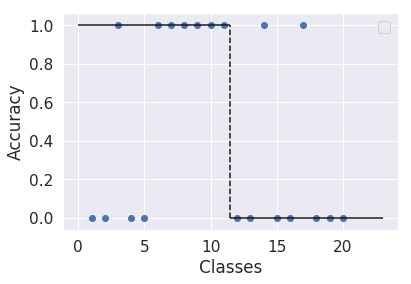

In [164]:
PRED_AN3 = []
for i, value in enumerate(prediction_AN3):
  value = value[0]
  if(value[0] > value[1]):
    PRED_AN3.append(1)
  else:
    PRED_AN3.append(0)
print(PRED_AN3)
CLASSES_AN3 = np.arange(1,21)
plt.scatter(CLASSES_AN3, PRED_AN3)
plt.vlines(11.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,11.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

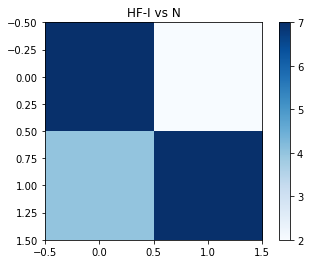

In [32]:
PRED_AN3 = [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
PRED_TRUEAN3 = [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]

cm_AN3 = confusion_matrix(PRED_TRUEAN3, PRED_AN3)
plt.imshow(cm_AN3, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("HF-I vs N")
plt.colorbar();

In [168]:
print("Accuracy: ", accuracy_score(PRED_TRUEAN3, PRED_AN3))
print("F1-Score: ", f1_score(PRED_TRUEAN3, PRED_AN3))     

Accuracy:  0.7
F1-Score:  0.7000000000000001


***Falla cardiaca sin infarto VS Hypertrofia***

In [11]:
AN_4 = paths_AN[11:35]
print(AN_4, AN_4.shape)
history_AN4, prediction_AN4 = classify(AN_4)

['/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-03/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-04/2/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-07/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-11/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-12/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-13/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-14/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-15/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-31/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-33/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-34/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-36/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-01/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-03/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-06/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-07/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-08/5/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-09/8/'
 '/content/gdrive/My D

W0731 04:13:45.108093 139658211006336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
5/5 [==============================] - 6s 1s/step - loss: 8.0479 - acc: 0.3750
Epoch 2/20
5/5 [==============================] - 4s 734ms/step - loss: 5.7626 - acc: 0.5000
Epoch 3/20
5/5 [==============================] - 3s 655ms/step - loss: 5.3631 - acc: 0.6000
Epoch 3/20
Epoch 4/20
5/5 [==============================] - 4s 773ms/step - loss: 3.7268 - acc: 0.6500
Epoch 5/20
5/5 [==============================] - 3s 660ms/step - loss: 3.9514 - acc: 0.5500
Epoch 6/20
5/5 [==============================] - 4s 743ms/step - loss: 3.7458 - acc: 0.6500
Epoch 7/20
5/5 [==============================] - 3s 692ms/step - loss: 3.6956 - acc: 0.5500
Epoch 8/20
5/5 [==============================] - 4s 742ms/step - loss: 3.4536 - acc: 0.8000
Epoch 9/20
5/5 [==============================] - 3s 687ms/step - loss: 3.4324 - acc: 0.6750
Epoch 10/20
5/5 [==============================] - 3s 694ms/step - loss: 3.3550 - acc: 0.7750
Epoch 11/20
5/5 [==============================] - 3s 680ms/s

W0731 04:45:00.267147 139658211006336 legend.py:1289] No handles with labels found to put in legend.


[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]


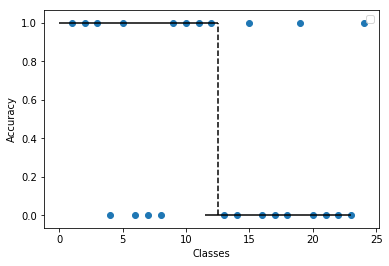

In [12]:
PRED_AN4 = []
for i, value in enumerate(prediction_AN4):
  value = value[0]
  if(value[0] > value[1]):
    PRED_AN4.append(1)
  else:
    PRED_AN4.append(0)
print(PRED_AN4)
CLASSES_AN4 = np.arange(1,25)
plt.scatter(CLASSES_AN4, PRED_AN4)
plt.vlines(12.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,12.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

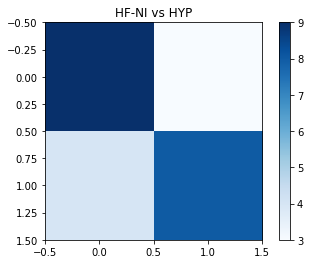

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

PRED_AN4 = [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
PRED_TRUEAN4 = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]

cm_AN4 = confusion_matrix(PRED_TRUEAN4, PRED_AN4)
plt.imshow(cm_AN4, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("HF-NI vs HYP")
plt.colorbar();

In [34]:
print("Accuracy: ", accuracy_score(PRED_TRUEAN4, PRED_AN4))
print("F1-Score: ", f1_score(PRED_TRUEAN4, PRED_AN4))     

Accuracy:  0.7083333333333334
F1-Score:  0.6956521739130435


***Falla cardiaca sin infarto VS Normal***

In [36]:
AN_5 = np.concatenate((paths_AN[11:23],paths_AN[35:]),axis=0)
print(AN_5)
history_AN5, prediction_AN5 = classify(AN_5)

['/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-03/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-04/2/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-07/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-11/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-12/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-13/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-14/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-15/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-31/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-33/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-34/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/1-HF-NI-36/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-02/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-03/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-05/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-06/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-07/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-09/7/'
 '/content/gdrive/My Drive/Tesis/A

W0731 05:48:19.653075 139658211006336 legend.py:1289] No handles with labels found to put in legend.


[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


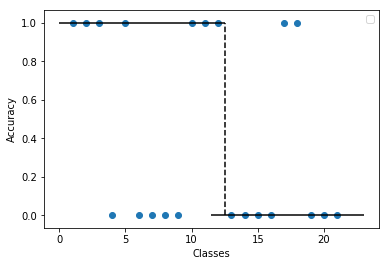

In [38]:
PRED_AN5 = []
for i, value in enumerate(prediction_AN5):
  value = value[0]
  if(value[0] > value[1]):
    PRED_AN5.append(1)
  else:
    PRED_AN5.append(0)
print(PRED_AN5)
CLASSES_AN5 = np.arange(1,22)
plt.scatter(CLASSES_AN5, PRED_AN5)
plt.vlines(12.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,12.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

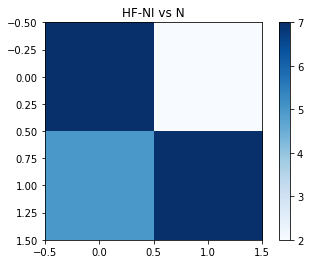

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

PRED_AN5 = [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
PRED_TRUEAN5 = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]

cm_AN5 = confusion_matrix(PRED_TRUEAN5, PRED_AN5)
plt.imshow(cm_AN5, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("HF-NI vs N")
plt.colorbar();

In [41]:
print("Accuracy: ", accuracy_score(PRED_TRUEAN5, PRED_AN5))
print("F1-Score: ", f1_score(PRED_TRUEAN5, PRED_AN5))     

Accuracy:  0.6666666666666666
F1-Score:  0.6666666666666666


***Hipertrofia VS Normal***

In [43]:
AN_5 = paths_AN[23:]
print(AN_5)
history_AN5, prediction_AN5 = classify(AN_5)

['/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-01/4/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-03/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-06/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-07/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-08/5/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-09/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-10/2/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-11/8/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-12/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-37/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-38/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/2-HYP-40/5/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-02/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-03/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-05/3/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-06/6/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-07/9/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-09/7/'
 '/content/gdrive/My Drive/Tesis/AN-PPM/3-N-10/8/'
 '/cont

W0731 06:30:02.673091 139658211006336 legend.py:1289] No handles with labels found to put in legend.


[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


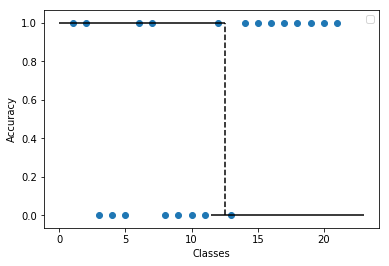

In [45]:
PRED_AN6 = []
for i, value in enumerate(prediction_AN5):
  value = value[0]
  if(value[0] > value[1]):
    PRED_AN6.append(1)
  else:
    PRED_AN6.append(0)
print(PRED_AN6)
CLASSES_AN6 = np.arange(1,22)
plt.scatter(CLASSES_AN6, PRED_AN6)
plt.vlines(12.5,0,1, colors='k', linestyles='dashed')
plt.hlines(0,11.5,23, colors='k')
plt.hlines(1,0,12.5, colors='k')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()

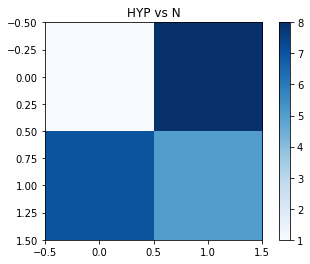

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

PRED_AN6 = [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
PRED_TRUEAN6 = [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]

cm_AN6 = confusion_matrix(PRED_TRUEAN6, PRED_AN6)
plt.imshow(cm_AN6, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("HYP vs N")
plt.colorbar();

In [48]:
print("Accuracy: ", accuracy_score(PRED_TRUEAN6, PRED_AN6))
print("F1-Score: ", f1_score(PRED_TRUEAN6, PRED_AN6))     

Accuracy:  0.2857142857142857
F1-Score:  0.4


***Prueba***

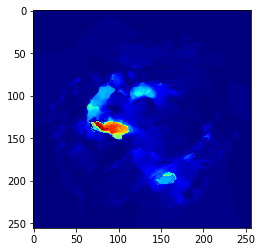

In [0]:
 a = '/content/gdrive/My Drive/Tesis/OF-PPM/0-HF-I-02/3/000013.ppm'
b = '/content/gdrive/My Drive/Tesis/OF-PPM/0-HF-I-02/3/000014.ppm'
a = plt.imread(a)
b = plt.imread(b)

img_a = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
img_b = cv2.cvtColor(b, cv2.COLOR_BGR2YCrCb)

imgsc_a = scale_ycrcb(img_a)[:,:,1:]
imgsc_b = scale_ycrcb(img_b)[:,:,1:]
mag_a, ang_a = arrowsimg(imgsc_a, 90)
mag_b, ang_b = arrowsimg(imgsc_b, 90)


vty_a, vtx_a = vel_tang(mag_a,imgsc_a[:,:,0], imgsc_a[:,:,1]) #VT_A        
vty_b, vtx_b = vel_tang(mag_b,imgsc_b[:,:,0], imgsc_b[:,:,1]) #VT_B
mag_vt = np.sqrt((vtx_a)**2 + (vty_a)**2)
vny, vnx, mag_vn = vel_normal(vty_a, vtx_a,mag_a,vty_b,vtx_b) #VN
mag_dev = acl_tan(mag_a,mag_b) #AT
an_ = acl_normal(mag_a,mag_vn) #AN
an_img = np.array(an_, dtype = np.uint8)
cinematic = cv2.applyColorMap(an_img, cv2.COLORMAP_JET)
#print(an_-cinematic)
plt.imshow(an_, cmap='jet')
#cv2.imwrite('/content/gdrive/My Drive/Tesis/DATASET/AN-PPM/prueba_1.jpg', cinematic)